# Random Forest Baseline
This is a basic random forest model for the purposes of data exploration and
establishing a basline performance which can be references when more
advanced models are used.

# Load Kaggle API Key and Libraries

In [1]:
#Initialise Kaggle API Key
!pip install -Uqq ipywidgets #This is already included in fastai but ah well
import ipywidgets as widgets
import os

def on_file_upload(change):
  if not os.path.exists("../root/.kaggle"):
    os.mkdir("../root/.kaggle")

  with open("../root/.kaggle/kaggle.json", "w") as file:
    file.write(str(btn_upload.data[-1])[2:-1])

  !chmod 600 "../root/.kaggle/kaggle.json"

btn_upload = widgets.FileUpload(accept='.json', multiple=False)
btn_upload.observe(on_file_upload, names='data')

display(widgets.Label('Upload \'kaggle.json\''), btn_upload)

Label(value="Upload 'kaggle.json'")

FileUpload(value={}, accept='.json', description='Upload')

In [2]:
#Imports
!pip install -Uqq fastai
!pip install -Uqq kaggle

import pandas as pd
import numpy as np

from fastai.tabular.all import *
from google.colab import files
from kaggle import api
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

     |████████████████████████████████| 194kB 4.4MB/s 
     |████████████████████████████████| 61kB 4.9MB/s 


# Load and Clean Data

In [3]:
#Download and extract kaggle data
api.competition_download_cli("homesite-quote-conversion")
file_extract("homesite-quote-conversion.zip")

#Extract all sub-directories and delete .zip files
for item in os.listdir():
  if item.endswith(".zip"): file_extract(item)
for item in os.listdir():
  if item.endswith(".zip"): os.remove(item)

  8%|▊         | 5.00M/62.0M [00:00<00:01, 49.2MB/s]

100%|██████████| 62.0M/62.0M [00:00<00:00, 138MB/s] 


In [4]:
#Load csv files
X_full = pd.read_csv("train.csv", parse_dates=['Original_Quote_Date'])
X_test_full = pd.read_csv("test.csv", parse_dates=['Original_Quote_Date'])

#Remove rows with missing target data (QuoteConversion_Flag)
X_full.dropna(axis=0, subset=['QuoteConversion_Flag'], inplace=True)

#Format dates
#This model actually performs better if dates are just dropped
#but I've included them just to demonstrate how this would be done
X_full["Year"] = X_full["Original_Quote_Date"].dt.year
X_full["Month"] = X_full["Original_Quote_Date"].dt.month
X_full["Day"] = X_full["Original_Quote_Date"].dt.day
X_test_full["Year"] = X_test_full["Original_Quote_Date"].dt.year
X_test_full["Month"] = X_test_full["Original_Quote_Date"].dt.month
X_test_full["Day"] = X_test_full["Original_Quote_Date"].dt.day
X_full = X_full.drop("Original_Quote_Date", axis=1)
X_test_full = X_test_full.drop("Original_Quote_Date", axis=1)

#Seperate target column from the rest of the data (seperate X from Y)
y = X_full.QuoteConversion_Flag
X_full.drop(['QuoteConversion_Flag'], axis=1, inplace=True)

#Split data for training
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, train_size=0.8, test_size=0.2, random_state=42)

#Select numrical columns
numerical_cols = [col for col in X_train_full.columns if X_train_full[col].dtype in ['int64', 'float64']]

#Select categorical columns (must have cardinality < 10)
categorical_cols = [col for col in X_train_full.columns if X_train_full[col].dtype == 'object' and X_train_full[col].nunique() < 10]

#Combine together to get all columns
selected_cols = numerical_cols + categorical_cols
X_train = X_train_full[selected_cols].copy()
X_valid = X_valid_full[selected_cols].copy()
X_test = X_test_full[selected_cols].copy()

In [5]:
#Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

#Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

#Define model
model = RandomForestClassifier(n_estimators=100, random_state=0)

#Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[
                      ('preprocessor', preprocessor),
                      ('model', model)
                      ])

# Fit and Predict

In [6]:
#Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

#Preprocessing of validation data, get predictions
preds = clf.predict(X_valid)

In [7]:
#Predict test csv for an 'official' kaggle submission
preds_final = clf.predict(X_test)

#Format and output to csv file
df_final = pd.DataFrame({
    "QuoteNumber": X_test.QuoteNumber,
    "QuoteConversion_Flag": preds_final
})

df_final.to_csv("submission.csv", index=False)

# Visualisations

In [8]:
#Compute Area Under the Receiver Operating Characteristic Curve
print("ROC AUC Score: " + str(roc_auc_score(y_valid, preds)))

ROC AUC Score: 0.80549992883288


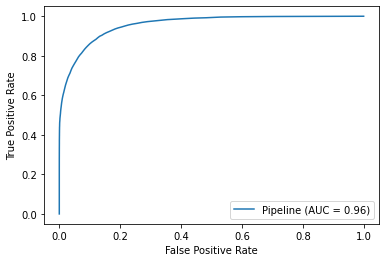

In [9]:
#Plot receiver operating characteristic curve
plot_roc_curve(clf, X_valid, y_valid)

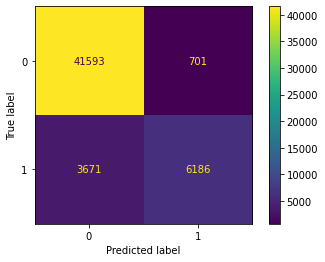

In [10]:
plot_confusion_matrix(clf, X_valid, y_valid, values_format='d')